In [0]:
# Please enter your own kaggle credentials by downloading the json file from kaggle 
import os
os.environ['KAGGLE_USERNAME'] = "ENTER_YOUR_USERNAME"
os.environ['KAGGLE_KEY'] = "ENTER_YOUR_KAGGLE_KEY"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# importing the libraries
import zipfile
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from PIL import Image
import tensorflow as tf

Using TensorFlow backend.


In [0]:
# Extracting the zip files to local workspace
zfile = zipfile.ZipFile('chest-xray-pneumonia.zip')
zfile.extractall()

In [0]:
zfile = zipfile.ZipFile('chest_xray.zip')
zfile.extractall()

In [0]:
## Run this model without transfer learning

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
#                  activation='relu',
#                  input_shape=(299, 299,3)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(64, (5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(1000, activation='relu'))
# model.add(Dense(2, activation='softmax'))

In [0]:
#imports the inception model and discards the lat layers
base_model= InceptionV3(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(512,activation='relu')(x) 
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

for layer in base_model.layers:
    layer.trainable = False
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
# Applying the optimizers
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    'chest_xray/train/',
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    'chest_xray/test/',
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


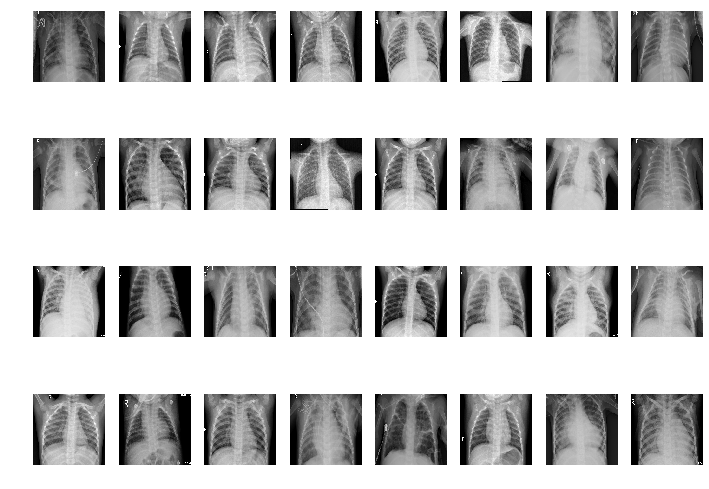

In [0]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [0]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 64

MODEL_FILE = 'pnumonia.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
100/100 [==============================] - 51s 509ms/step - loss: 0.3456 - acc: 0.8563 - val_loss: 1.0913 - val_acc: 0.6315
Epoch 2/5
100/100 [==============================] - 45s 449ms/step - loss: 0.2492 - acc: 0.8953 - val_loss: 0.6334 - val_acc: 0.7290
Epoch 3/5
100/100 [==============================] - 45s 449ms/step - loss: 0.2210 - acc: 0.9091 - val_loss: 0.6338 - val_acc: 0.7190
Epoch 4/5
100/100 [==============================] - 46s 460ms/step - loss: 0.1905 - acc: 0.9253 - val_loss: 0.9351 - val_acc: 0.6625
Epoch 5/5
100/100 [==============================] - 46s 463ms/step - loss: 0.2260 - acc: 0.9038 - val_loss: 0.9704 - val_acc: 0.6391


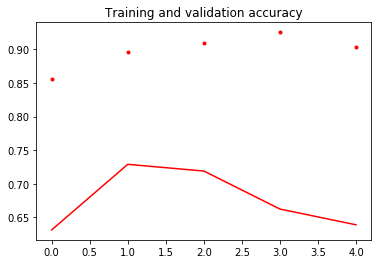

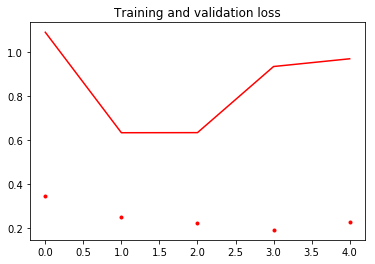

In [0]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

In [0]:
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("normal", "pneumonia")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [0]:
# loading the model
model = load_model(MODEL_FILE)

In [0]:
def predict_output(filepath):
  """
    Predicts the output for the given image.
    Args:
        filepath: file path for the image to be predicted
    Returns:
        preds: the predicted disease with its probability 
  """
  img = image.load_img(filepath, target_size=(299, 299))
  preds = predict(model, img)

  plot_preds(np.asarray(img), preds)
  return preds

array([0.66508096, 0.33491907], dtype=float32)

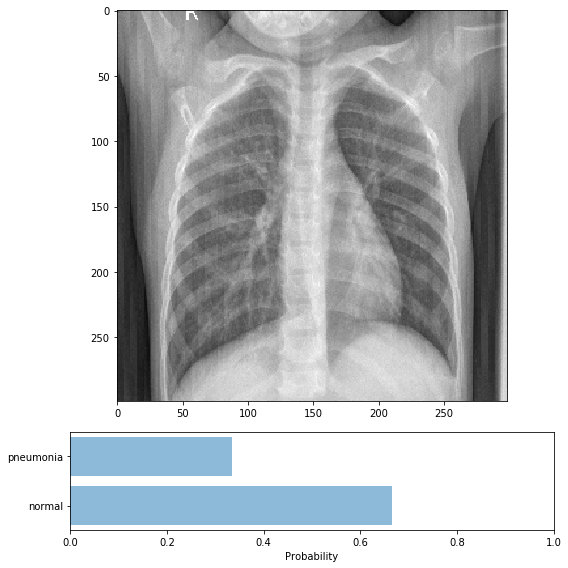

In [0]:
predict_output('chest_xray/test/NORMAL/IM-0009-0001.jpeg')

array([0.06998526, 0.9300147 ], dtype=float32)

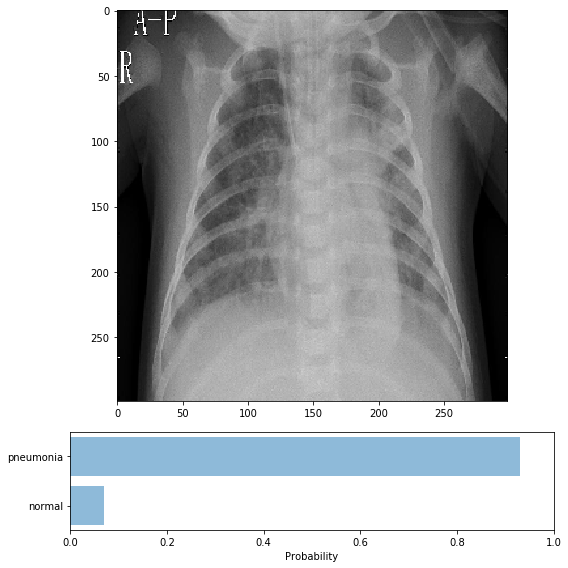

In [0]:
predict_output('chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg')